# Importing necessary libraries

In [1]:
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import load_img, img_to_array

# 1. Datset Loading and Splitting

In [2]:
# Download and extract the COIL dataset using kagglehub
path = kagglehub.dataset_download("codebreaker619/columbia-university-image-library")
print("Path to dataset files:", path)

100%|██████████| 18.7M/18.7M [00:01<00:00, 18.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/codebreaker619/columbia-university-image-library/versions/1


In [3]:
# Load images from the COIL dataset
def load_images(dataset_path, img_size=(128, 128)):
    images = []
    for img_file in os.listdir(dataset_path):
        img_path = os.path.join(dataset_path, img_file)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

In [4]:
def load_images(dataset_path, img_size=(128, 128)):
    images = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = load_img(img_path, target_size=img_size)
                images.append(img_to_array(img))
    return np.array(images)

In [5]:
# Dataset loading
dataset_path = os.path.join(path, "coil-20/coil-20-proc")
print("Using dataset path:", dataset_path)

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The dataset path '{dataset_path}' does not exist. Please verify.")

images = load_images(dataset_path)
print(f"Loaded {len(images)} images with shape {images[0].shape}.")

Using dataset path: /root/.cache/kagglehub/datasets/codebreaker619/columbia-university-image-library/versions/1/coil-20/coil-20-proc
Loaded 1440 images with shape (128, 128, 3).


In [6]:
# Split dataset into training (80%) and testing (20%) sets
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

# 2. Model development (Using Autoencoder)

In [7]:
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    latent = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(latent)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    reconstructed = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(inputs=input_img, outputs=reconstructed)
    return autoencoder

In [8]:
# Instantiate the model
input_shape = X_train.shape[1:]
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

# 3. Training the model

In [10]:
# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, X_test)
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 12367.6484 - val_loss: 12544.9688
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 12456.6182 - val_loss: 12544.8789
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 12401.4443 - val_loss: 12544.8564
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 12740.6396 - val_loss: 12544.8379
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 12597.1279 - val_loss: 12544.8271
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 12507.9229 - val_loss: 12544.8223
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 12731.0107 - val_loss: 12544.8164
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 12409.9756 - val_loss: 12544.8145
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 12610.0869 - val_loss: 12544.8125
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 12216.7715 - val_loss: 12544.8105


# 4. Evaluate and Visulaize

In [11]:
# Evaluate the model
test_loss = autoencoder.evaluate(X_test, X_test)
print(f"Final Test MSE: {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 12135.3340
Final Test MSE: 12544.8105


**Inference :**
The final test MSE of 12,544.81 indicates a significant reconstruction error, which is consistent with the observed low fidelity of reconstructed images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


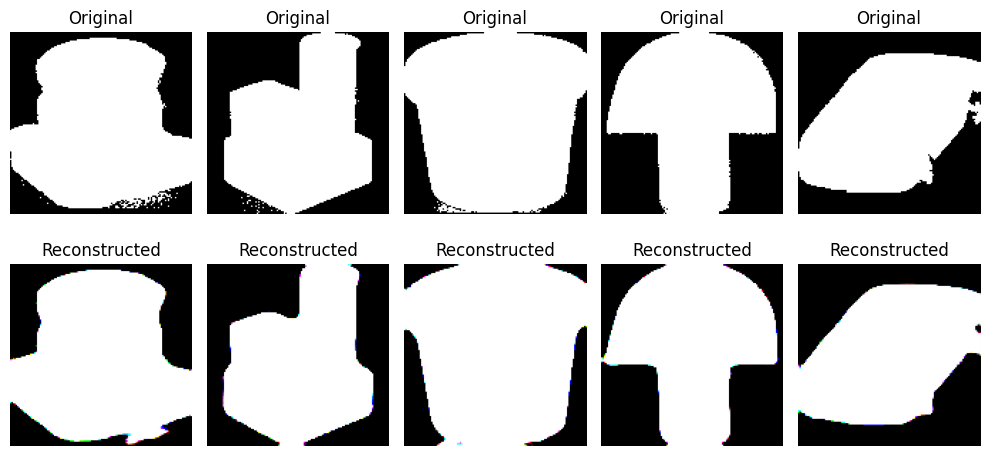

In [12]:
# Visualize the reconstructed images
def visualize_reconstruction(autoencoder, test_images, n=5):
    reconstructed_images = autoencoder.predict(test_images[:n])
    plt.figure(figsize=(10, 5))
    for i in range(n):
        # Original image
        plt.subplot(2, n, i + 1)
        plt.imshow(test_images[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed image
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_reconstruction(autoencoder, X_test)

**Inference:** The reconstructed images resemble the original ones in shape and structure but exhibit blurriness and loss of finer details, indicating that the autoencoder struggled to capture intricate patterns.
This suggests that the latent space representation is not sufficiently expressive.

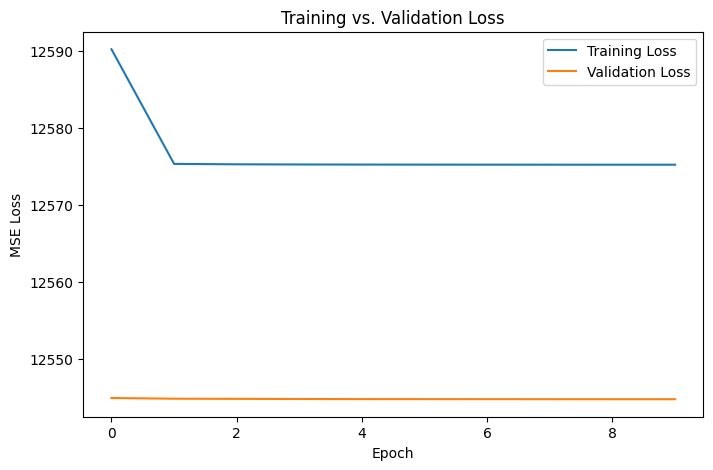

In [13]:
# Plot the loss curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

**Inference :**
The training loss started high and gradually decreased but plateaued after a few epochs, suggesting that the model stopped learning further improvements.
The validation loss remained constant throughout training, indicating a potential issue like a too-simple model architecture that cannot learn effectively from the data.
